In [63]:
import uproot 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px


In [64]:
my_tuple = uproot.open("Lb2JpsiLambda_newstart.root:Hlt2BandQ_Lb2JpsiLambdaTTTuple/Tuple")

In [65]:
my_tuple.keys()

['EVENTNUMBER',
 'Hlt2_Hlt2BandQ_Lb2JpsiLambdaTTDecision',
 'Hlt2_TCK',
 'RUNNUMBER',
 'Lb_END_VZ',
 'Lb_END_VX',
 'Lb_END_VY',
 'Lb_END_VRHO',
 'Lb_BPVCORRM',
 'Lb_BPVDIRA',
 'Lb_BPVETA',
 'Lb_BPVIPCHI2',
 'Lb_BPVFDCHI2',
 'Lb_BPVLTIME',
 'Lb_BPVFD',
 'Lb_BPVFDIRX',
 'Lb_BPVFDIRY',
 'Lb_BPVFDIRZ',
 'Lb_BPVFDVECX',
 'Lb_BPVFDVECY',
 'Lb_BPVFDVECZ',
 'Lb_BPVIP',
 'Lb_BPVVDRHO',
 'Lb_BPVVDX',
 'Lb_BPVVDY',
 'Lb_BPVVDZ',
 'Lb_COMB_MASS',
 'Lb_MAXDOCA',
 'Lb_MAXDOCACHI2',
 'Lb_MAXSDOCA',
 'Lb_MAXSDOCACHI2',
 'Lb_TRUEID',
 'Lb_TRUEKEY',
 'Lb_TRUEPT',
 'Lb_TRUEPX',
 'Lb_TRUEPY',
 'Lb_TRUEPZ',
 'Lb_TRUEENERGY',
 'Lb_TRUEP',
 'Lb_TRUEFOURMOMENTUME',
 'Lb_TRUEFOURMOMENTUMX',
 'Lb_TRUEFOURMOMENTUMY',
 'Lb_TRUEFOURMOMENTUMZ',
 'Lb_TRUEORIGINVZ',
 'Lb_TRUEORIGINVX',
 'Lb_TRUEORIGINVY',
 'Lb_TRUEENDVZ',
 'Lb_TRUEENDVX',
 'Lb_TRUEENDVY',
 'Lb_BKGCAT',
 'Lb_MC_MOTHER_ID',
 'Lb_MC_MOTHER_KEY',
 'Lb_MC_GD_MOTHER_ID',
 'Lb_MC_GD_MOTHER_KEY',
 'Lb_MC_GD_GD_MOTHER_ID',
 'Lb_MC_GD_GD_MOTHER_KEY',
 'Lb_MASS

In [66]:
#keys = my_tuple.keys()
keys = ["Jpsi_PT","Lambda0_END_VRHO","Lambda0_BPVDIRA","Lambda0_BPVIP","Lambda0_BPVIPCHI2","Lambda0_MASS","Lb_BPVDIRA","Lb_BPVIP","Lb_BPVVDRHO","Lb_MAXSDOCA","Lb_P","Lb_PT","Lb_CHI2","Lambda0_TRUEENDVZ","Lb_BKGCAT","p_plus_PID_P","p_plus_PID_K","p_plus_MINIP","p_plus_P","p_plus_PT","pi_minus_P","pi_minus_PT"]

In [67]:
signal_data = my_tuple.arrays(keys,library="pd", cut="(Lb_BKGCAT==0)&(Lambda0_TRUEENDVZ > 2500)")
bg_data = my_tuple.arrays(keys,library="pd", cut="(Lb_BKGCAT!=0)|(Lambda0_TRUEENDVZ < 2500)")

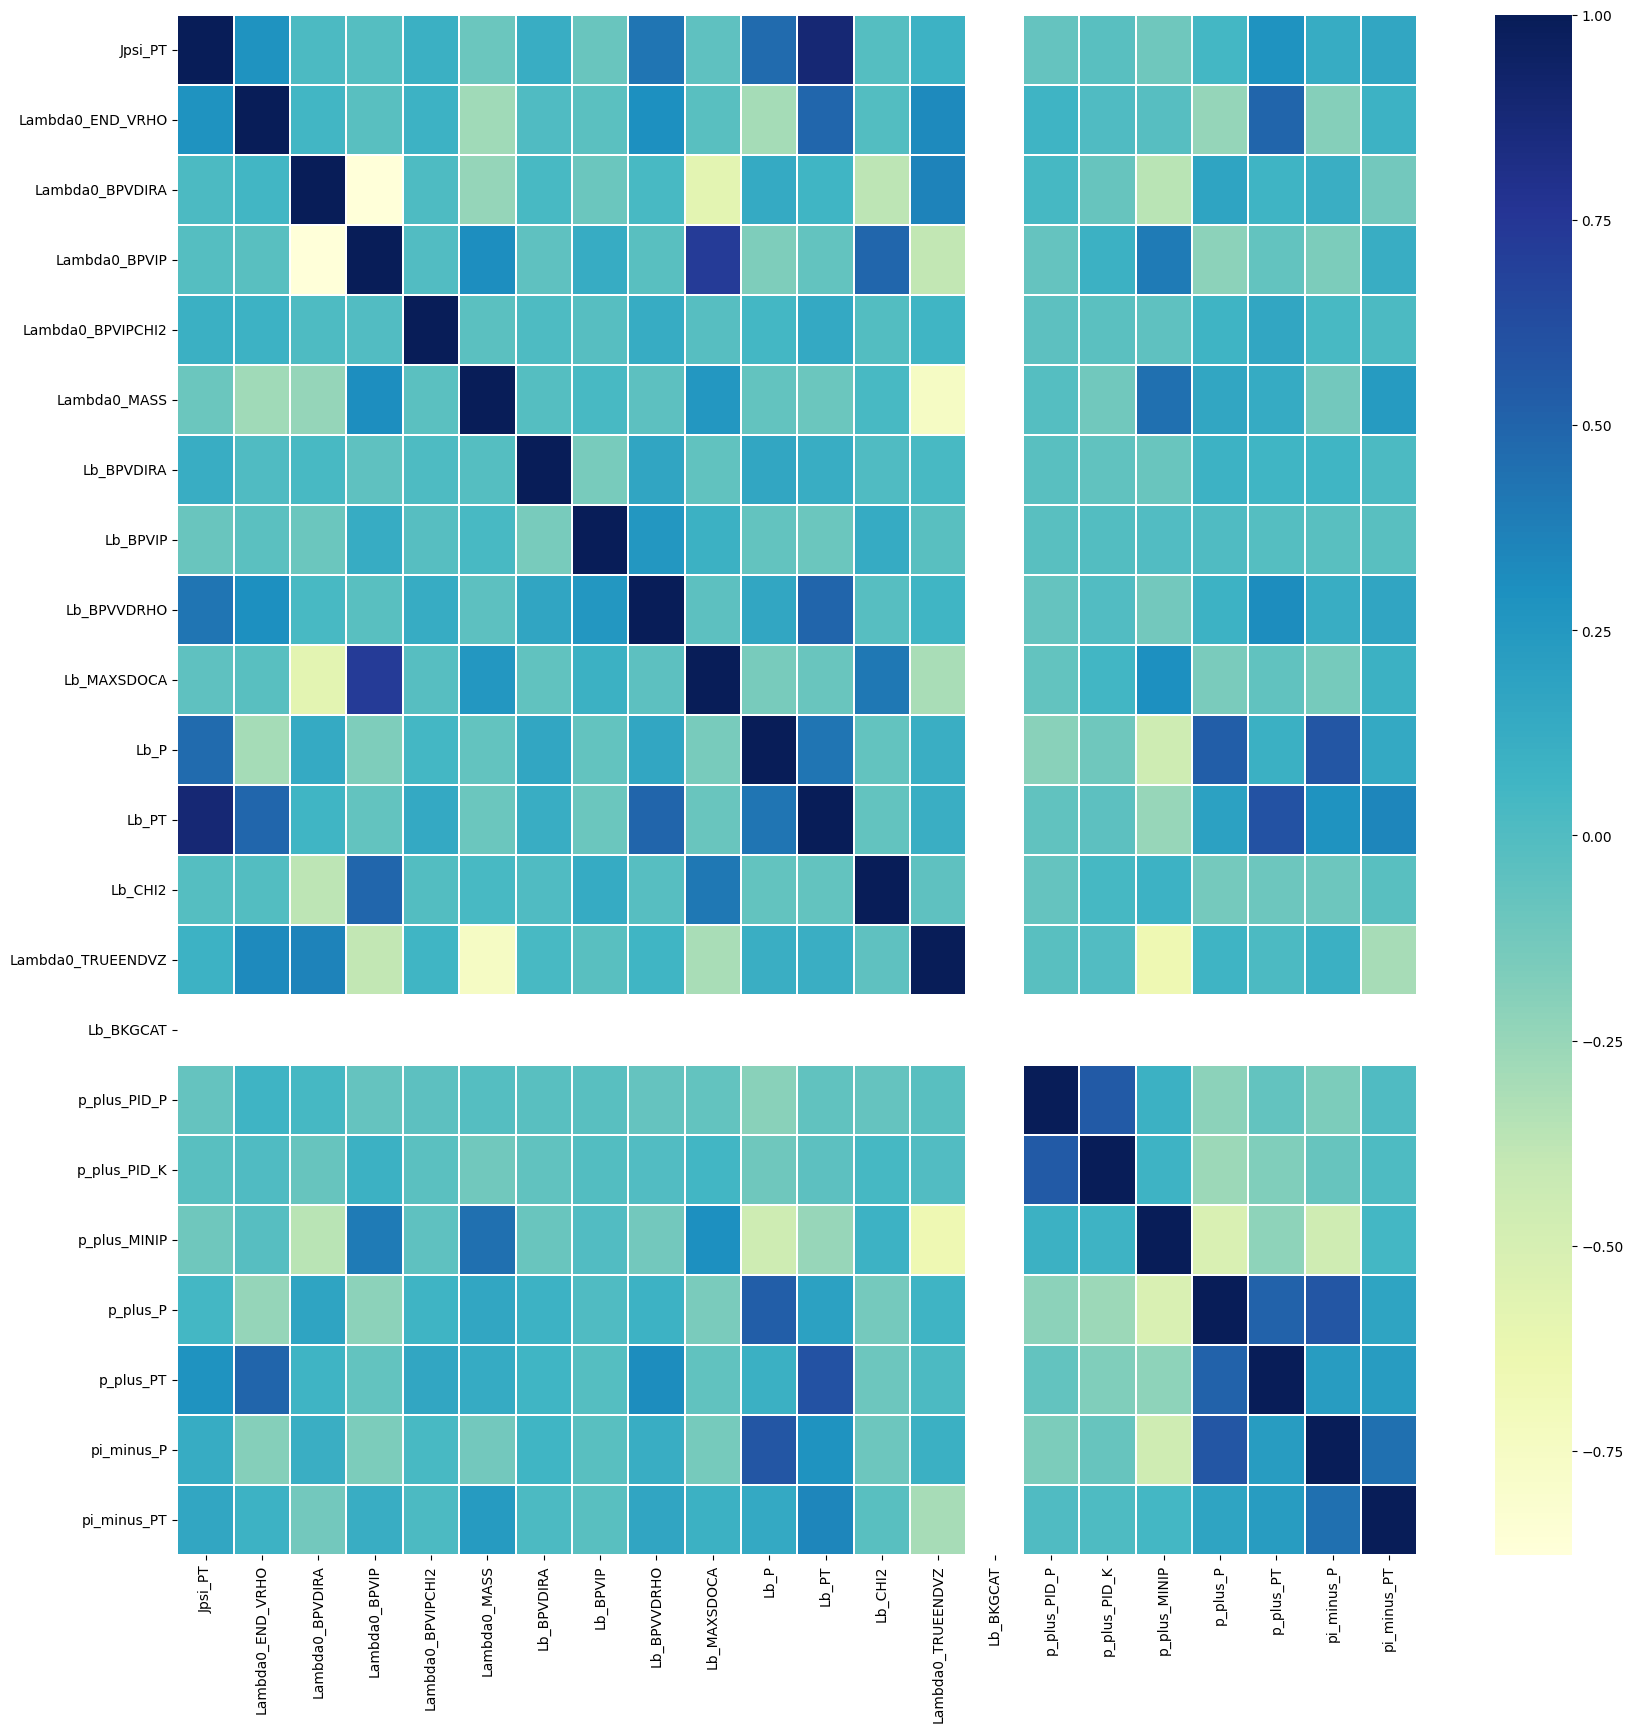

In [68]:
f, ax = plt.subplots(figsize =(20, 20))
sns.heatmap(signal_data.corr(), ax = ax, cmap ="YlGnBu", linewidths = 0.1)
plt.show()

In [69]:
bg_data

,Jpsi_PT,Lambda0_END_VRHO,Lambda0_BPVDIRA,Lambda0_BPVIP,Lambda0_BPVIPCHI2,Lambda0_MASS,Lb_BPVDIRA,Lb_BPVIP,Lb_BPVVDRHO,Lb_MAXSDOCA,...,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_PID_P,p_plus_PID_K,p_plus_MINIP,p_plus_P,p_plus_PT,pi_minus_P,pi_minus_PT
0,1225.936035,128.525024,1.000000,2.550493,0.128797,1456.652841,0.998280,0.057469,0.077550,0.185515,...,0.131193,5264.282715,100,-13.732962,-10.816402,121.017967,25809.289062,785.947266,30725.232422,902.943787
1,1225.936035,86.543015,0.999988,19.366659,10.185701,2015.703227,0.998564,0.052533,0.077519,1.646221,...,10.223073,NaN,100,-7.622521,1.132468,121.589699,46649.707031,2154.184082,9805.192383,951.565186
2,1686.010498,147.625778,0.999931,48.511082,2.039056,2975.714032,0.999997,0.015476,0.219391,16.977539,...,2.043888,3004.373047,110,10.542446,1.390965,141.003952,66823.203125,2939.823242,5392.572266,1242.578491
3,1686.010498,131.517761,0.999970,25.852182,0.998390,1927.627557,0.999800,0.136714,0.219391,7.129308,...,0.985421,NaN,100,-17.044121,-19.421448,239.891418,22479.873047,1674.655762,5392.572266,1242.578491
4,2185.920898,155.021835,1.000000,1.292275,0.022351,1769.957980,0.998780,0.163199,0.158862,1.150952,...,0.035215,NaN,100,-8.604069,-9.160099,248.598984,22325.716797,1577.698486,5435.133301,1142.575073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8570,2415.513916,201.215561,0.999993,22.560287,3.175020,1380.584613,0.999849,0.102237,0.070467,24.115036,...,7.005995,NaN,100,0.645450,1.910944,55.627167,78182.812500,2725.733398,6047.137695,597.363159
8572,2098.724854,151.828094,0.999994,18.562542,2.147376,1842.600201,0.999220,0.044744,0.091599,0.308833,...,2.170305,NaN,100,-13.149837,-5.800742,151.640121,37572.398438,1328.275635,7014.323242,1055.259277
8573,3465.086670,139.623169,1.000000,2.664159,0.256947,1598.735829,0.999966,0.177989,0.966514,3.148116,...,0.355034,NaN,100,6.997914,5.434317,178.206436,32085.611328,620.513428,12989.652344,1906.983276
8574,4927.255859,118.963707,0.999936,45.805363,4.892081,1653.016939,0.999993,0.016435,0.138252,25.622189,...,4.907872,1148.892944,50,-12.181843,-1.133159,28.645836,71204.242188,2242.005859,13685.699219,942.602844


In [70]:
signal_data

,Jpsi_PT,Lambda0_END_VRHO,Lambda0_BPVDIRA,Lambda0_BPVIP,Lambda0_BPVIPCHI2,Lambda0_MASS,Lb_BPVDIRA,Lb_BPVIP,Lb_BPVVDRHO,Lb_MAXSDOCA,...,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_PID_P,p_plus_PID_K,p_plus_MINIP,p_plus_P,p_plus_PT,pi_minus_P,pi_minus_PT
9,3913.011230,1251.987061,0.999999,11.967562,3.090436,1140.225690,0.999846,0.023786,0.221441,0.128070,...,8.018241,6664.610840,0,0.000000,0.000000,74.407280,22974.615234,4322.593262,5021.975098,924.475647
13,2510.226562,197.934296,1.000000,6.440488,0.671770,1190.556383,1.000000,0.007850,0.633140,0.456041,...,1.022276,6023.783203,0,7.298761,2.048832,24.293640,107464.812500,3093.601318,11471.593750,406.190704
28,4606.722168,214.491043,1.000000,5.285466,0.057519,2148.220426,0.999999,0.022421,0.589447,3.414481,...,0.885457,4383.386230,0,3.687189,1.684036,35.877403,144955.093750,6431.525391,10963.268555,693.068115
30,3002.961670,197.230774,0.999980,34.650650,9.969265,1888.307112,0.999987,0.070501,0.225770,24.366753,...,9.849626,5065.246094,0,1.049875,0.443821,81.085091,154207.953125,4457.308594,6622.287109,844.959778
39,4373.695312,225.855286,0.999986,26.915697,2.689625,1664.092771,0.999443,0.051971,0.127753,13.112944,...,3.378011,3995.272217,0,10.254707,5.936031,115.392990,38567.113281,1074.935181,11345.168945,1457.553101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,6528.130859,698.821899,0.999966,34.283234,13.019949,1681.494053,0.999991,0.058197,1.916327,8.122602,...,13.324399,3042.945312,0,0.000000,0.000000,141.200165,35625.871094,6858.212891,4830.845215,259.131409
8565,5846.209473,561.566528,0.999999,9.444826,1.859222,1110.707882,1.000000,0.010429,1.054829,5.068877,...,1.745814,6343.325684,0,21.597973,6.254457,29.928791,60080.187500,5349.999023,11213.935547,857.661743
8571,6769.180176,772.121094,0.999994,20.648920,2.288667,1453.504042,1.000000,0.001553,0.414612,2.787241,...,2.315368,5109.767090,0,-1.796330,2.850732,85.341461,39029.523438,5691.383301,3545.564453,205.570740
8576,2669.717773,249.749908,1.000000,2.677685,0.062142,1465.905266,0.999840,0.027567,0.050105,0.335133,...,0.574919,4921.216797,0,1.349308,1.561659,35.491657,101079.296875,4302.797852,18993.458984,1511.003662


In [71]:
training_data = signal_data.merge(bg_data.dropna().sample(len(signal_data)),how='outer')
training_data

,Jpsi_PT,Lambda0_END_VRHO,Lambda0_BPVDIRA,Lambda0_BPVIP,Lambda0_BPVIPCHI2,Lambda0_MASS,Lb_BPVDIRA,Lb_BPVIP,Lb_BPVVDRHO,Lb_MAXSDOCA,...,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_PID_P,p_plus_PID_K,p_plus_MINIP,p_plus_P,p_plus_PT,pi_minus_P,pi_minus_PT
0,3913.011230,1251.987061,0.999999,11.967562,3.090436,1140.225690,0.999846,0.023786,0.221441,0.128070,...,8.018241,6664.610840,0,0.000000,0.000000,74.407280,22974.615234,4322.593262,5021.975098,924.475647
1,2510.226562,197.934296,1.000000,6.440488,0.671770,1190.556383,1.000000,0.007850,0.633140,0.456041,...,1.022276,6023.783203,0,7.298761,2.048832,24.293640,107464.812500,3093.601318,11471.593750,406.190704
2,4606.722168,214.491043,1.000000,5.285466,0.057519,2148.220426,0.999999,0.022421,0.589447,3.414481,...,0.885457,4383.386230,0,3.687189,1.684036,35.877403,144955.093750,6431.525391,10963.268555,693.068115
3,3002.961670,197.230774,0.999980,34.650650,9.969265,1888.307112,0.999987,0.070501,0.225770,24.366753,...,9.849626,5065.246094,0,1.049875,0.443821,81.085091,154207.953125,4457.308594,6622.287109,844.959778
4,4373.695312,225.855286,0.999986,26.915697,2.689625,1664.092771,0.999443,0.051971,0.127753,13.112944,...,3.378011,3995.272217,0,10.254707,5.936031,115.392990,38567.113281,1074.935181,11345.168945,1457.553101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,5302.447266,169.244156,0.999983,19.353027,10.715669,1570.542502,0.999974,0.031249,0.263893,23.103073,...,15.970388,2090.336670,0,18.934158,4.203182,177.746567,37129.429688,1551.228760,6622.541016,1320.574829
3438,4676.785156,155.971161,0.999950,48.013981,43.533634,1123.006233,0.999981,0.087031,0.416937,46.058239,...,42.761658,5775.586426,50,8.571741,0.717251,37.706528,63516.425781,2496.301270,10745.210938,662.296997
3439,1655.333130,225.865585,0.999935,55.565151,12.050667,2453.928177,0.999677,0.152282,0.095562,37.986820,...,20.442440,2137.663086,100,6.975451,3.623053,256.331390,24667.050781,1782.835815,8561.802734,1596.433838
3440,1790.072144,334.676666,0.999945,34.363735,4.229661,1967.301896,0.999942,0.066256,0.576115,11.686765,...,4.914734,1416.969360,0,7.479004,-4.283858,159.116318,32467.550781,4282.794922,3457.847656,840.349426


In [72]:
training_data['SIGNAL'] = False
mask =(training_data['Lb_BKGCAT'] == 0)
training_data.loc[mask,'SIGNAL'] = True
mask = (training_data['Lambda0_TRUEENDVZ'] < 2500)
training_data.loc[mask,'SIGNAL'] = False

In [73]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [74]:
to_drop = ["SIGNAL", "Lb_BKGCAT", "Lambda0_TRUEENDVZ"]


In [75]:
X_tr, X_eval = train_test_split(training_data)
y_tr = X_tr.SIGNAL
y_tr_clean = y_tr == True
X_tr_copy = X_tr.copy()
X_tr.drop(columns=to_drop, inplace=True)

In [76]:
y_eval =  X_eval.SIGNAL
y_eval_clean = y_eval == True
X_eval_copy = X_eval.copy()
X_eval.drop(columns=to_drop, inplace=True)

In [77]:
X_eval.columns

Index(['Jpsi_PT', 'Lambda0_END_VRHO', 'Lambda0_BPVDIRA', 'Lambda0_BPVIP',
       'Lambda0_BPVIPCHI2', 'Lambda0_MASS', 'Lb_BPVDIRA', 'Lb_BPVIP',
       'Lb_BPVVDRHO', 'Lb_MAXSDOCA', 'Lb_P', 'Lb_PT', 'Lb_CHI2',
       'p_plus_PID_P', 'p_plus_PID_K', 'p_plus_MINIP', 'p_plus_P', 'p_plus_PT',
       'pi_minus_P', 'pi_minus_PT'],
      dtype='object')

In [62]:
model_params = {
    'iterations': 5000, 
    'loss_function': 'Logloss',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'od_type': 'IncToDec',
}

In [78]:
train_dataset = Pool(X_tr, y_tr_clean, feature_names=list(X_tr.columns))
eval_dataset = Pool(X_eval, y_eval_clean, feature_names=list(X_eval.columns))

In [79]:
model = CatBoostClassifier(**model_params,custom_metric=['Logloss',
                   'AUC:hints=skip_train~false','Accuracy'])
model.fit(train_dataset, verbose=True, plot=False)

Learning rate set to 0.00353
0:	learn: 0.6918041	total: 2.78ms	remaining: 13.9s
1:	learn: 0.6905790	total: 4.54ms	remaining: 11.3s
2:	learn: 0.6894055	total: 6.33ms	remaining: 10.5s
3:	learn: 0.6881920	total: 8.08ms	remaining: 10.1s
4:	learn: 0.6868579	total: 9.82ms	remaining: 9.81s
5:	learn: 0.6857652	total: 11.6ms	remaining: 9.63s
6:	learn: 0.6844904	total: 13.3ms	remaining: 9.49s
7:	learn: 0.6832216	total: 15.1ms	remaining: 9.4s
8:	learn: 0.6821481	total: 16.8ms	remaining: 9.33s
9:	learn: 0.6809290	total: 18.6ms	remaining: 9.3s
10:	learn: 0.6797632	total: 20.4ms	remaining: 9.24s
11:	learn: 0.6784766	total: 22.2ms	remaining: 9.23s
12:	learn: 0.6773711	total: 24ms	remaining: 9.21s
13:	learn: 0.6762448	total: 25.7ms	remaining: 9.17s
14:	learn: 0.6750916	total: 27.5ms	remaining: 9.14s
15:	learn: 0.6739318	total: 29.3ms	remaining: 9.12s
16:	learn: 0.6728401	total: 31.1ms	remaining: 9.11s
17:	learn: 0.6717173	total: 32.8ms	remaining: 9.07s
18:	learn: 0.6706078	total: 34.5ms	remaining: 9.0

222:	learn: 0.5469389	total: 398ms	remaining: 8.52s
223:	learn: 0.5465874	total: 400ms	remaining: 8.52s
224:	learn: 0.5462431	total: 402ms	remaining: 8.53s
225:	learn: 0.5459433	total: 403ms	remaining: 8.52s
226:	learn: 0.5456261	total: 405ms	remaining: 8.52s
227:	learn: 0.5453438	total: 407ms	remaining: 8.52s
228:	learn: 0.5449785	total: 409ms	remaining: 8.52s
229:	learn: 0.5446963	total: 411ms	remaining: 8.52s
230:	learn: 0.5443579	total: 413ms	remaining: 8.52s
231:	learn: 0.5440343	total: 415ms	remaining: 8.52s
232:	learn: 0.5437347	total: 416ms	remaining: 8.52s
233:	learn: 0.5434511	total: 418ms	remaining: 8.52s
234:	learn: 0.5430838	total: 420ms	remaining: 8.51s
235:	learn: 0.5427121	total: 422ms	remaining: 8.51s
236:	learn: 0.5423222	total: 423ms	remaining: 8.51s
237:	learn: 0.5420032	total: 425ms	remaining: 8.51s
238:	learn: 0.5416378	total: 427ms	remaining: 8.51s
239:	learn: 0.5412724	total: 429ms	remaining: 8.5s
240:	learn: 0.5409358	total: 431ms	remaining: 8.5s
241:	learn: 0.

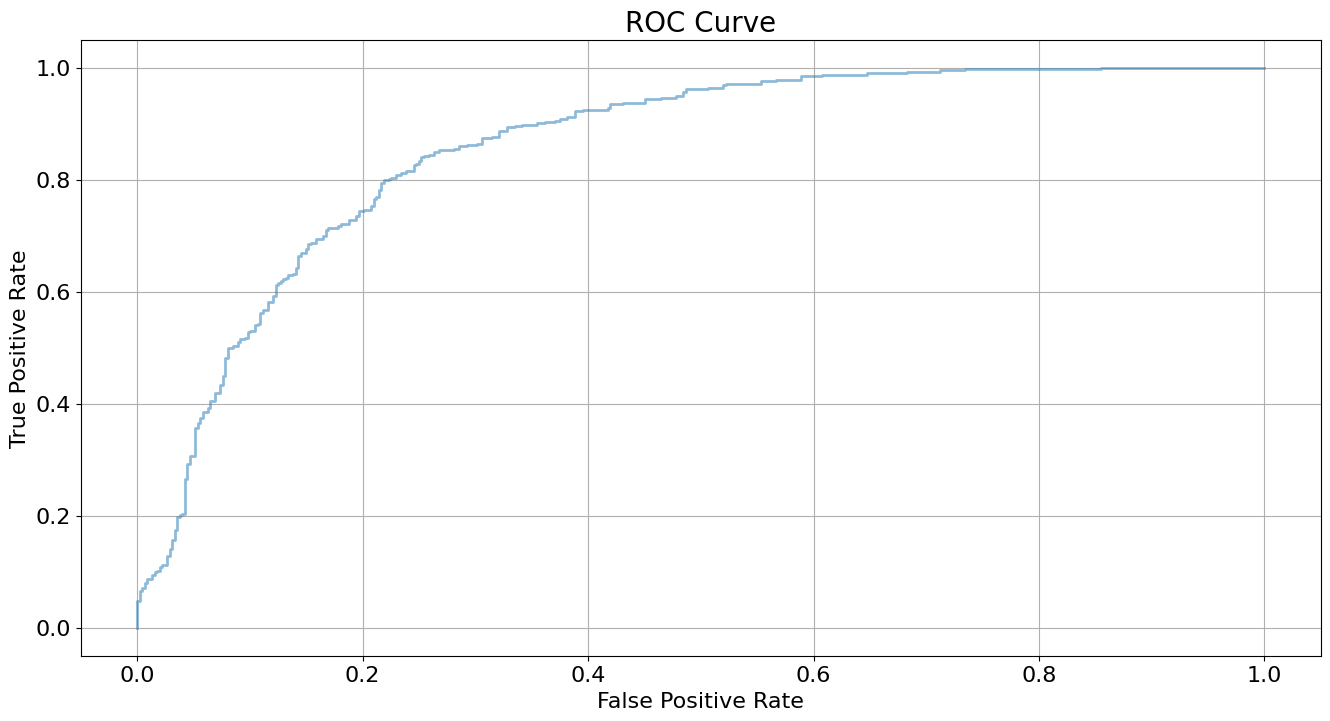

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00223214, 0.00223214, 0.00223214, 0.00223214,
        0.00223214, 0.00223214, 0.00223214, 0.00223214, 0.00446429,
        0.00446429, 0.00446429, 0.00669643, 0.00669643, 0.00669643,
        0.00669643, 0.00669643, 0.00892857, 0.00892857, 0.00892857,
        0.00892857, 0.01116071, 0.01339286, 0.01339286, 0.01339286,
        0.01339286, 0.015625  , 0.015625  , 0.015625  , 0.01785714,
        0.01785714, 0.02008929, 0.02008929, 0.02008929, 0.02008929,
        0.02232143, 0.02232143, 0.02455357, 0.02678571, 0.02678571,
        0.02678571, 0.02678571, 0.02678571, 0.02678571, 0.02678571,
        0.02678571, 0.02901786, 0.02901786, 0.02901786, 0.02901786,
        0.02901786, 0.02901786, 0.03125   , 0.03

In [80]:
plt.rcParams["figure.figsize"] = (4,4)
get_roc_curve(model, 
              eval_dataset,
              thread_count=-1,
              plot=True)

In [81]:
print(model.get_best_score())


{'learn': {'Accuracy': 0.974041069352964, 'Logloss': 0.2037637393076501, 'AUC': 0.9970175678824612}}


Text(0.5, 0, 'CatBoost Feature Importance')

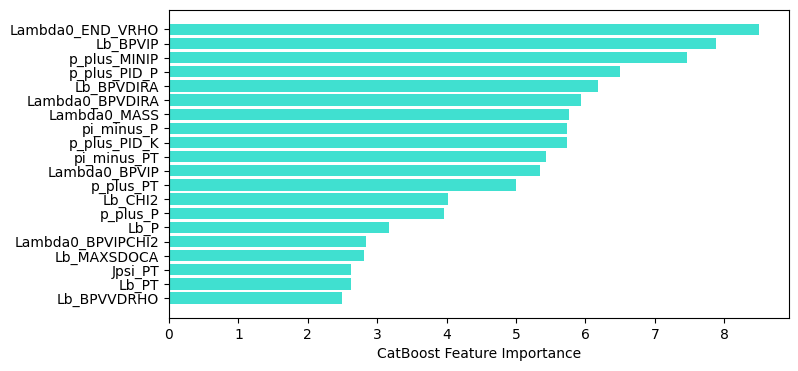

In [82]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (8,4)
plt.barh(X_eval.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [83]:
signal_MVA_prob_eval = model.predict_proba(X_eval_copy)
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_eval]
X_eval_copy['signal_MVA'] = signal_MVA_probs

signal_MVA_prob_tr = model.predict_proba(X_tr_copy)
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_tr]
X_tr_copy['signal_MVA'] = signal_MVA_probs

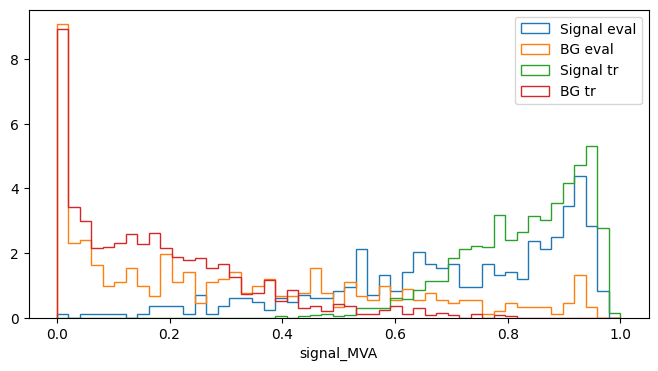

In [84]:
fig, ax = plt.subplots()

density = True

variable = 'signal_MVA'

bins = np.linspace(0,1,50)

n_sig,bins_sig, _ = ax.hist(X_eval_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal eval",histtype='step',density=density)
n_bg,bins_bg, _ = ax.hist(X_eval_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG eval",histtype='step',density=density)

ax.hist(X_tr_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal tr",histtype='step',density=density)
ax.hist(X_tr_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG tr",histtype='step',density=density)

ax.legend()

plt.xlabel(variable)
plt.show()

In [85]:
len(signal_data)

1721